In [85]:
# 第3回データサイエンス入門

import pandas as pd  # 表形式のデータを扱うために pandas を使用する
kakei = pd.read_csv("Pythonデータサイエンス入門/kakei.csv", encoding="Shift_JIS")  # 家計調査年報データを読み込む

移動平均の項数を入力してください：3
調査年
2008            NaN
2009    2393.333333
2010    2296.000000
2011    2253.000000
2012    2240.666667
2013    2174.666667
2014    2018.666667
2015    1895.666667
2016    1859.000000
2017    1901.000000
2018            NaN
Name: 支出金額, dtype: float64


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25903 (\N{CJK UNIFIED IDEOGRAPH-652F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda

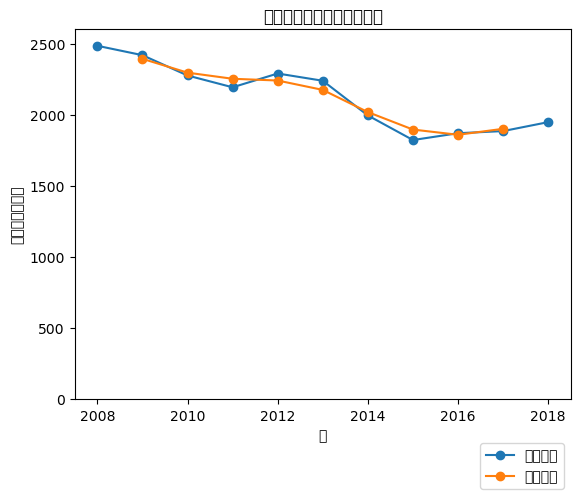

In [86]:
#(1) 移動平均モデル


# コード4.11 支出金額の移動平均の計算
# 米の支出金額のみを取り出す
rice = kakei[kakei["収支分類区分3"] == "米"]

# 項数に応じて期間の中心の年の支出金額の移動平均を計算
rice.index = rice["調査年"]
n = int(input("移動平均の項数を入力してください："))
ma_rice = rice["支出金額"].rolling(n, center=True).mean()
print(ma_rice)

# 年ごとの支出金額
## 元データの描画設定
plt.plot(rice.index, rice["支出金額"], label="生データ", marker='o')
## 移動平均を求めたデータの描画設定
plt.plot(ma_rice.index, ma_rice, label="移動平均", marker='o')
## グラフの要素設定
plt.title("各年の支出金額の移動平均")
plt.xlabel("年")
plt.ylabel("支出金額（円）")
plt.ylim(0, 2600)
plt.legend(bbox_to_anchor=(1, -0.1), loc='upper right')
plt.show()

調査年
2008         NaN
2009         NaN
2010   -4.066852
2011   -1.872822
2012   -0.547418
2013   -2.945552
2014   -7.173513
2015   -6.093131
2016   -1.934236
2017    2.259279
2018         NaN
Name: 支出金額, dtype: float64


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31859 (\N{CJK UNIFIED IDEOGRAPH-7C73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/

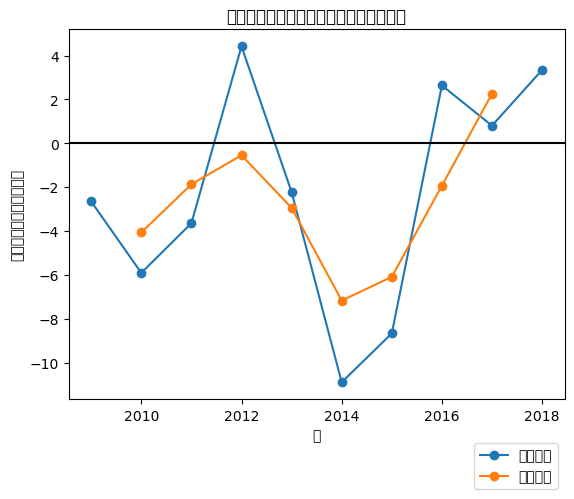

In [87]:
# コード4.12 支出金額の変化率の移動平均の計算
# 支出金額の変化率を計算する
raw = rice["支出金額"].pct_change() * 100
ma_change = ma_rice.pct_change() * 100
ma_change[2018] = None # 変化率の計算で最後の年が 0 になるため無効にする
print(ma_change)

## 変化率のグラフを描画する
plt.plot(raw.index, raw, label="生データ", marker='o')
plt.plot(ma_change.index, ma_change, label="移動平均", marker = 'o')
plt.title("各年の米の支出金額の変化率の移動平均")
plt.xlabel("年")
plt.ylabel("支出金額の変化率（％）")
plt.legend(bbox_to_anchor=(1, -0.1), loc='upper right')
plt.axhline(0, color="black")
plt.show()

In [88]:
#(2) 指数平滑化モデル

# コード4.13 指数平滑法による予測値を計算する関数
import numpy as np

def calc_forecasted_value(df, alpha):
    """
    指数平滑法を用いて予測値を計算する関数
    """
    # データフレームのコピーを作成
    res = df.copy()
    # 時間の列をインデックスに設定
    res.index = res["調査年"]
    
    # 予測値を格納する辞書（キー：調査年）
    forecasted = {res.index[0]: np.nan}  # 最初の年は予測できないので NaN
    forecasted[res.index[1]] = res.at[res.index[0], "支出金額"]  # 最初の年の値を次の年の予測値とする
    # 予測値を順次求めていく
    for t in range(2, len(res)):
        pre_year = res.index[t - 1]
        year_t = res.index[t]
        forecasted[year_t] = alpha * res.at[pre_year, "支出金額"] + (1 - alpha) * forecasted[pre_year]
    
    # 辞書の値（予測値）を列として追加
    res.loc[:, "予測値"] = forecasted.values()
    # 予測値と実測値から予測誤差を計算
    res["予測誤差"] = abs(res["支出金額"] - res["予測値"])
    
    return res

In [89]:
# 第4回データサイエンス入門

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
from sklearn.metrics import r2_score

df = pd.read_csv("Pythonデータサイエンス入門/choco_ice.csv", encoding="sjis")
df

,日最高気温の平均(℃),year,month,チョコレート【円/日】,アイスクリーム・シャーベット【円/日】,feb
0,17.0,2009,11,12.166667,13.400000,0
1,12.4,2009,12,15.032258,14.193548,0
2,11.0,2010,1,14.709677,11.677419,0
3,9.9,2010,2,40.071429,10.892857,1
4,13.2,2010,3,13.193548,12.354839,0
...,...,...,...,...,...,...
109,12.1,2018,12,22.645161,17.322581,0
110,10.3,2019,1,25.451613,15.935484,0
111,11.6,2019,2,49.428571,15.107143,1
112,15.4,2019,3,22.935484,17.483871,0


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/

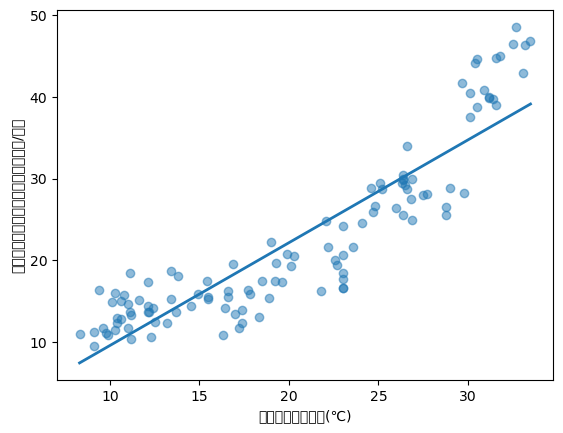

In [90]:
#(3) 線形単回帰

#  コード1：線形単回帰
x_name = '日最高気温の平均(℃)'
y_name = 'アイスクリーム・シャーベット【円/日】'

x = df[x_name].values
y = df[y_name].values
a, b = np.polyfit(x, y, deg=1)
r2 = r2_score(y, a*x + b)

# アイスクリームの回帰直線
plt.scatter(x, y, alpha=0.5)
x_minmax = np.array([x.min(), x.max()])
y_pred = a * x_minmax + b
plt.plot(x_minmax, y_pred, linewidth=2)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/

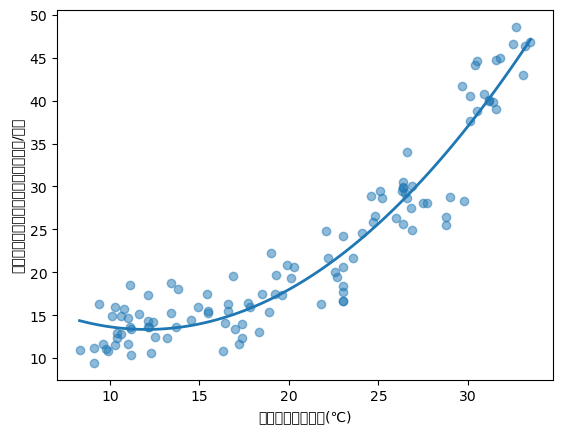

In [91]:
# コード2：次数2の単回帰
x_name = '日最高気温の平均(℃)'
y_name = 'アイスクリーム・シャーベット【円/日】'

x = df[x_name].values
y = df[y_name].values
a2, a1, b = np.polyfit(x, y, deg=2)
r2 = r2_score(y, a2 * x**2 + a1 * x + b)

# アイスクリームの回帰曲線
plt.scatter(x, y, alpha=0.5)
x_minmax = np.linspace(x.min(), x.max(), 100)
y_pred = a2 * x_minmax**2 + a1 * x_minmax + b
plt.plot(x_minmax, y_pred, linewidth=2)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nishiyamashoutou/opt/

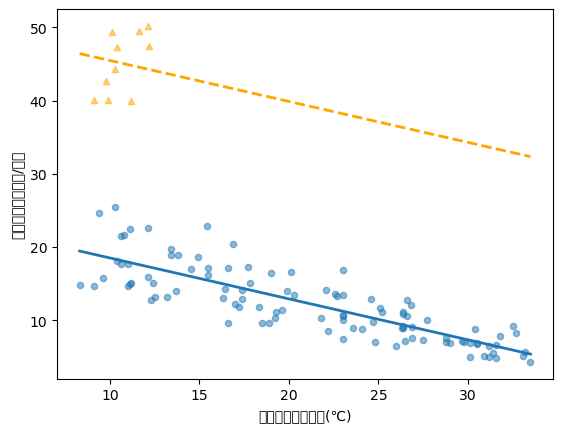

In [92]:
#(4) 重回帰

# コード3：説明変数が2つの場合の重回帰
from sklearn.linear_model import LinearRegression

x = df[['日最高気温の平均(℃)', 'feb']].values
y = df['チョコレート【円/日】'].values

lr = LinearRegression()
lr.fit(x, y)
a1, a2 = lr.coef_
b = lr.intercept_
r2 = r2_score(y, a1 * x[:,0] + b + a2 * x[:,1])


# ダミー変数を導入したチョコレートの回帰直線
x_minmax = np.array([x[:,0].min(), x[:,0].max()])
y_pred = a1 * x_minmax + b
x_name = "日最高気温の平均(℃)"
y_name = "チョコレート【円/日】"
ax = df[df.feb==0].plot(kind='scatter', x=x_name, y=y_name, alpha=0.5)
df[df.feb==1].plot(kind='scatter', x=x_name, y=y_name, marker='^', ax=ax, alpha=0.5, color="orange")
plt.plot(x_minmax, y_pred, linewidth=2)
plt.plot(x_minmax, y_pred + a2, linewidth=2, linestyle="dashed", color="orange")
plt.show()

In [93]:
#(5) 最小二乗法

In [94]:
#(6) サポートベクターマシン (関数系で予測出来てたら性能比較対象として採用)

In [95]:
#第5回・第6回 Pythonによる機械学習入門

係数 [[3.]]
切片 [-2.]


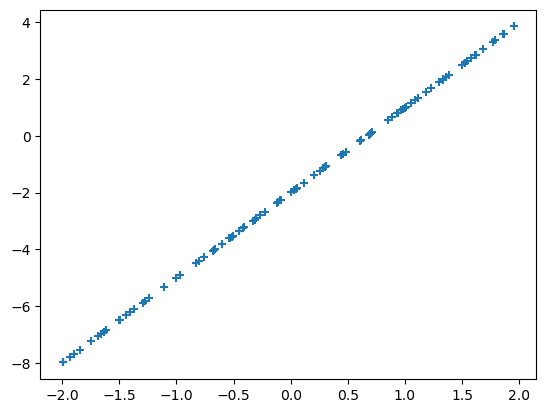

In [96]:
#(7) 線形単回帰

import matplotlib.pyplot as plt
import numpy as np


### y = 3x -2 のデータを作成
x = np.random.rand(100, 1)  # 0 〜 1 までの乱数を 100 個つくる
x = x * 4 - 2  # 値の範囲を -2 〜 2 に変更
y = 3 * x - 2  # y = 3x - 2


### 学習
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x, y)


### 係数、切片を表示
print('係数', model.coef_)
print('切片', model.intercept_)


### グラフ表示
plt.scatter(x, y, marker='+')
plt.show()

係数 [[2.85164259]]
切片 [-1.89611804]
決定係数 0.9011948515206435


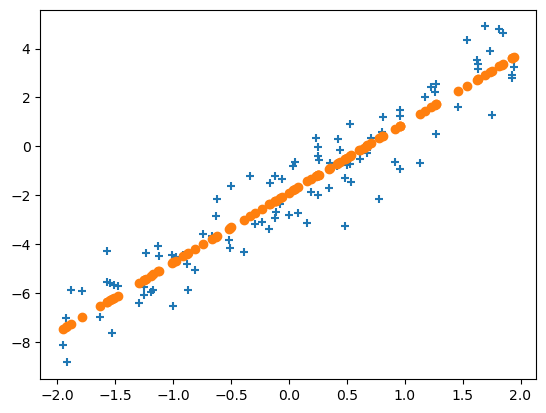

In [97]:
## バラつきのある y = 3x -2 のデータを作成
x = np.random.rand(100, 1)  # 0 〜 1 までの乱数を 100 個つくる
x = x * 4 - 2               # 値の範囲を -2 〜 2 に変更
y = 3 * x - 2  # y = 3x - 2
y += np.random.randn(100, 1)  # 標準正規分布（平均 0, 標準偏差 1）の乱数を加える


### 学習
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x, y)


### 係数、切片、決定係数を表示
print('係数', model.coef_)
print('切片', model.intercept_)
r2 = model.score(x, y)
print('決定係数', r2)


### グラフ表示
plt.scatter(x, y, marker ='+')
plt.scatter(x, model.predict(x), marker='o')
plt.show()

係数 [[ 3. -2.]]
切片 [1.]
決定係数 1.0


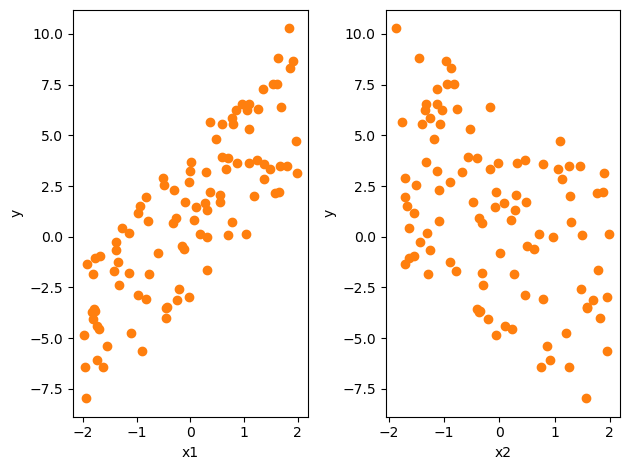

In [98]:
#(8) 重回帰

import matplotlib.pyplot as plt
import numpy as np


### y = 3x_1 - 2x_2 + 1 のデータを作成
x1 = np.random.rand(100, 1)  # 0 〜 1 までの乱数を 100 個つくる
x1 = x1 * 4 - 2              # 値の範囲を -2 〜 2 に変更
x2 = np.random.rand(100, 1)  # x2 についても同様
x2 = x2 * 4 - 2
y = 3 * x1 - 2 * x2 + 1


### 学習
from sklearn import linear_model
x1_x2 = np.c_[x1, x2]  # [[x1_1, x2_1], [x1_2, x2_2], ..., [x1_100, x2_100]] という形に変換
model = linear_model.LinearRegression()
model.fit(x1_x2, y)


### 係数、切片、決定係数を表示
print('係数', model.coef_)
print('切片', model.intercept_)
print('決定係数', model.score(x1_x2, y))


### グラフ表示
y_ = model.predict(x1_x2)  # 求めた回帰式で予測
plt.subplot(1, 2, 1)
plt.scatter(x1, y, marker='+')
plt.scatter(x1, y_, marker='o')
plt.xlabel('x1')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.scatter(x2, y, marker='+')
plt.scatter(x2, y_, marker='o')
plt.xlabel('x2')
plt.ylabel('y')

plt.tight_layout()
plt.show()

係数 [[ 3.04205352 -2.02229831]]
切片 [0.90329696]
決定係数 0.9551569654139657


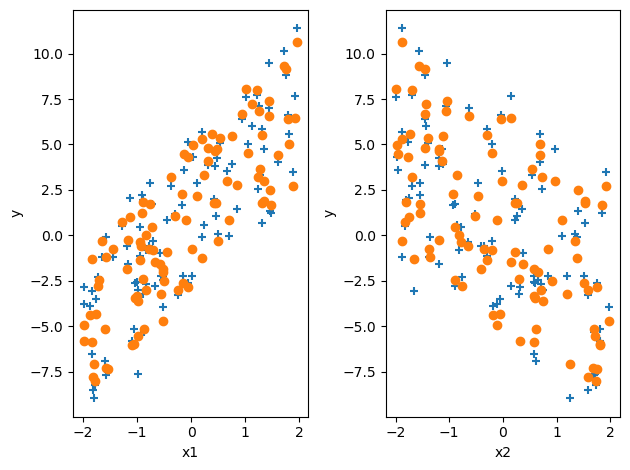

In [99]:
import matplotlib.pyplot as plt
import numpy as np


### バラつきのある y = 3x_1 - 2x_2 + 1 のデータを作成

x1 = np.random.rand(100, 1)  # 0 〜 1 までの乱数を 100 個つくる
x1 = x1 * 4 - 2              # 値の範囲を -2 〜 2 に変更
x2 = np.random.rand(100, 1)  # x2 についても同様
x2 = x2 * 4 - 2
y = 3 * x1 - 2 * x2 + 1
y += np.random.randn(100, 1)  # 標準正規分布（平均 0, 標準偏差 1）の乱数を加える


### 学習
from sklearn import linear_model
x1_x2 = np.c_[x1, x2]  # [[x1_1, x2_1], [x1_2, x2_2], ..., [x1_100, x2_100]] という形に変換
model = linear_model.LinearRegression()
model.fit(x1_x2, y)


### 係数、切片、決定係数を表示
print('係数', model.coef_)
print('切片', model.intercept_)
print('決定係数', model.score(x1_x2, y))


### グラフ表示
y_ = model.predict(x1_x2)  # 求めた回帰式で予測

plt.subplot(1, 2, 1)
plt.scatter(x1, y, marker='+')
plt.scatter(x1, y_, marker='o')
plt.xlabel('x1')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.scatter(x2, y, marker='+')
plt.scatter(x2, y_, marker='o')
plt.xlabel('x2')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [100]:
import math

import numpy as np
import matplotlib.pyplot as plt


### バラつきのある正弦波データを作成

x = np.random.rand(1000, 1)  # 0 〜 1 までの乱数を 1000 個つくる
x = x * 20 - 10              # 値の範囲を -10 〜 10 に変更

y = np.array([math.sin(v) for v in x])  # 正弦波カーブ
y += np.random.randn(1000)  # 標準正規分布（平均 0, 標準偏差 1）の乱数を加える

係数 [0.02518247]
切片 -0.009744001721872009
決定係数 0.014589261651070329


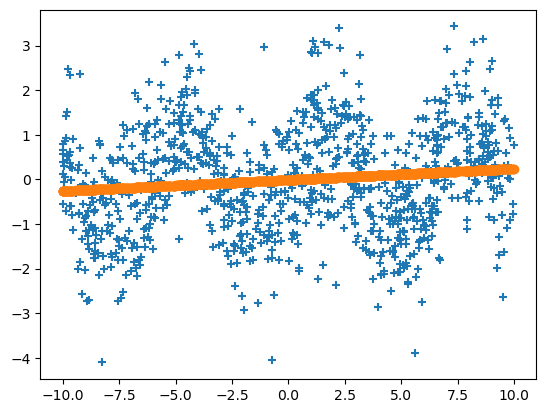

In [101]:
#(9) 最小二乗法

from sklearn import linear_model


model = linear_model.LinearRegression()
model.fit(x, y)


### 係数、切片、決定係数を表示

print('係数', model.coef_)
print('切片', model.intercept_)

r2 = model.score(x, y)
print('決定係数', r2)


### グラフ表示

plt.scatter(x, y, marker='+')
plt.scatter(x, model.predict(x), marker='o')
plt.show()

決定係数 0.13102970097215094


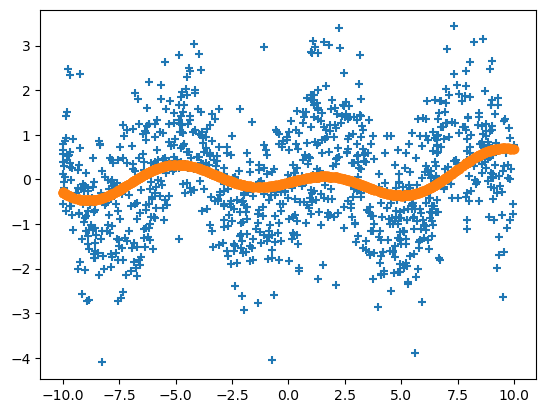

In [102]:
#(10) サポートベクターマシン (関数系で予測出来てたら性能比較対象として採用)

model = svm.SVR()
model.fit(x, y)


### 決定係数を表示
r2 = model.score(x, y)
print('決定係数', r2)


### グラフ表示

plt.scatter(x, y, marker='+')
plt.scatter(x, model.predict(x), marker='o')
plt.show()

In [103]:
#第9回 知識ゼロからの機械学習入門

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import datasets

import pandas_datareader.data as dr
stock=dr.DataReader('AAPL',"stooq")
stock.head()

stock['Next_High']=stock['High'].shift(1)
stock.head()

stock.isnull().sum()
stock=stock.dropna()
stock.shape

data_columns=['Open','High','Low','Close','Volume']
test_rows=500
target=stock['Next_High']
data=stock[data_columns]

target_train=target[test_rows:]
target_test=target[:test_rows]
data_train=data[test_rows:]
data_test=data[:test_rows]

from sklearn.metrics import mean_squared_error
mean_squared_error(target_test,target_predict)

10.93253237162389

4.045804135363473

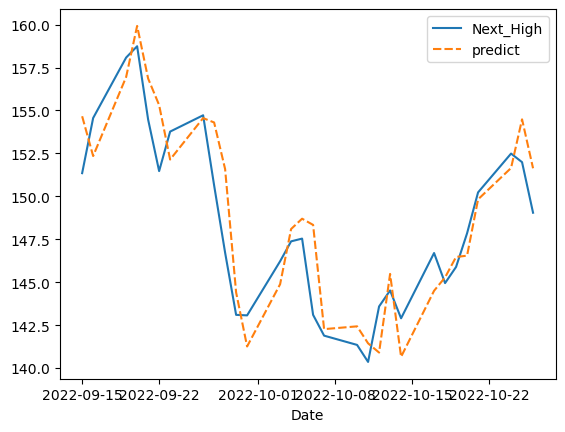

In [104]:
# (11) 線形(単)回帰

from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(data_train,target_train)

target_predict=model.predict(data_test)
result=pd.DataFrame(target_test)
result['predict']=target_predict

sns.lineplot(data=result[:30])

mean_squared_error(target_test,target_predict)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.325e+01, tolerance: 3.856e+01
  model = cd_fast.enet_coordinate_descent(


4.127523363249842

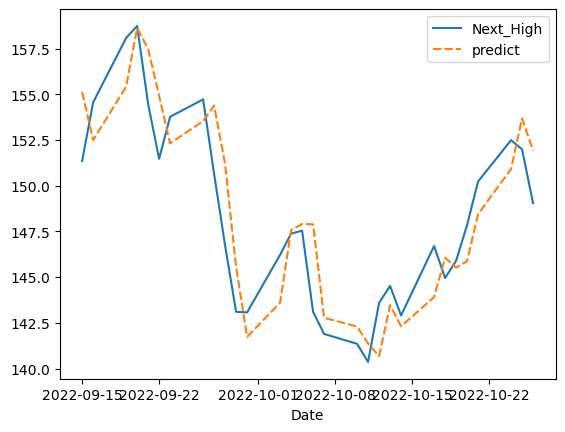

In [105]:
#(12) Lasso回帰

from sklearn.linear_model import Lasso
model=Lasso()
model.fit(data_train,target_train)

target_predict=model.predict(data_test)
result=pd.DataFrame(target_test)
result['predict']=target_predict

sns.lineplot(data=result[:30])

mean_squared_error(target_test,target_predict)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.08173e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


4.04414517130814

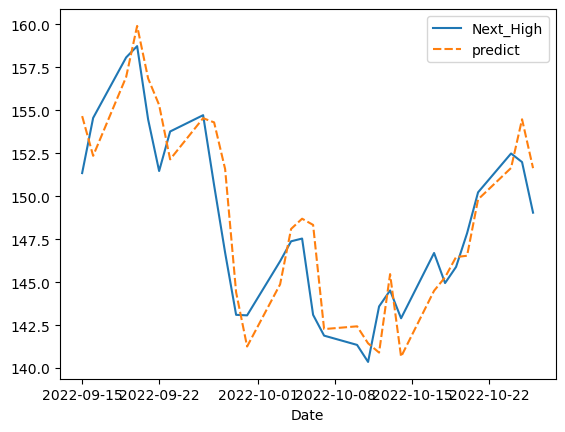

In [106]:
#(13) Ridge回帰

from sklearn.linear_model import Ridge
model=Ridge(alpha=1.0)

model.fit(data_train,target_train)

target_predict=model.predict(data_test)
result=pd.DataFrame(target_test)
result['predict']=target_predict

sns.lineplot(data=result[:30])

mean_squared_error(target_test,target_predict)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.741e+01, tolerance: 3.856e+01
  model = cd_fast.enet_coordinate_descent(


4.316040763550194

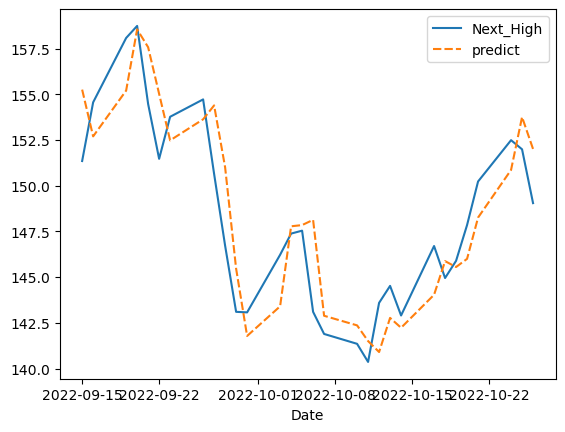

In [107]:
#(14) Elastic回帰

from sklearn.linear_model import ElasticNet
model=ElasticNet()

model.fit(data_train,target_train)

target_predict=model.predict(data_test)
result=pd.DataFrame(target_test)
result['predict']=target_predict

sns.lineplot(data=result[:30])

mean_squared_error(target_test,target_predict)

In [108]:
#第12回 日経ソフトウェア2022年7月号

import pandas as pd
df = pd.read_csv("日経ソフトウェア2022年7月/ice_sales.csv")
df.head()

,temp,sales
0,7.5,5.8
1,8.0,8.2
2,11.1,8.9
3,16.2,10.3
4,21.3,10.4


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


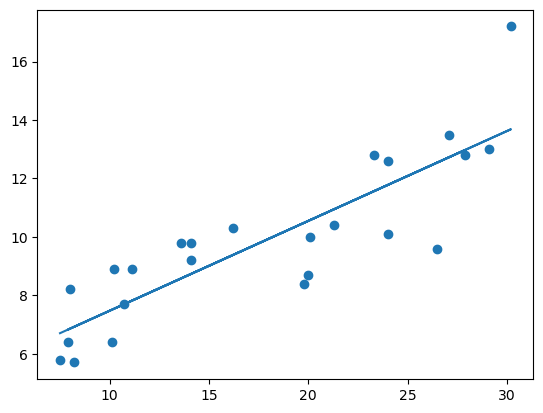

In [109]:
# 線形回帰(ライブラリ使用)

x = df.temp.to_frame()
y = df.sales

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x, y)

lr.predict([[30]])

lr.score(x, y)

import matplotlib.pyplot as plt
plt.scatter(df.temp, df.sales)
plt.plot(df.temp, lr.predict(x))
plt.show()

In [110]:
# 線形回帰(ライブラリ未使用)

def myFit(x, y):
  s = 0   # 各データからの距離の2乗の総和
  min_s = 1000000   # 最小のsを初期化
  
  # 傾きと切片の取り得る最大値を計算
  res = []
  for i in range(len(x) - 1):
    res.append((y[i+1] - y[i]) / (x[i+1] - x[i]))
  max_a = (sum(res) / len(res))   # 傾きの取り得る最大値
  max_b = sum(y) / len(y)   # 切片の取り得る最大値

  tick_max_a = [i/10 for i in range(int(max_a+1)*10)]
  tick_max_b = [i/10 for i in range(int(max_b+1)*10)]

  # tmp_bを0から0.1ずつmax_bまで変化させる
  for tmp_b in tick_max_b:    
    # tmp_aを0から0.1ずつmax_aまで変化させる
    for tmp_a in tick_max_a:   
      # 各データからの距離の2乗の総和（s）を求める
      for i in range(len(x)):   
      
        s = s + (y[i] - (tmp_a * x[i] + tmp_b))**2 
      
      if min_s > s :   # sが最小かどうかを判定する
        min_s = s
        min_a = round(tmp_a, 1)
        min_b = round(tmp_b, 1)
        
      s = 0
    tmp_a = 0
    
  print("回帰式：y =", min_a, "* x +", min_b)
  
  return min_a, min_b

In [111]:
import numpy as np

x = [2, 4, 6]
y = [2, 3, 5]

a, b = myFit(x, y)

# テストデータ
x = [6, 7, 8, 10, 12, 15, 19, 20]
y = [7, 3, 5,  6, 10,  3, 10, 12]

a, b = myFit(x, y)

coe = np.polyfit(x, y, 1)
a = coe[0]
b = coe[1]
print("回帰式：y =", a, "* x +", b)

a, b = myFit(df.temp, df.sales)

def myPredict(val, a, b):
  y = a * val + b
  return y

sales = myPredict(30, a, b)
print(sales)

回帰式：y = 0.8 * x + 0.1
回帰式：y = 0.4 * x + 2.2
回帰式：y = 0.38940234134319157 * x + 2.278496611213796
回帰式：y = 0.3 * x + 4.5
13.5


In [112]:
# 第10回 AIデータサイエンスのための図解でわかる数学プログラミング

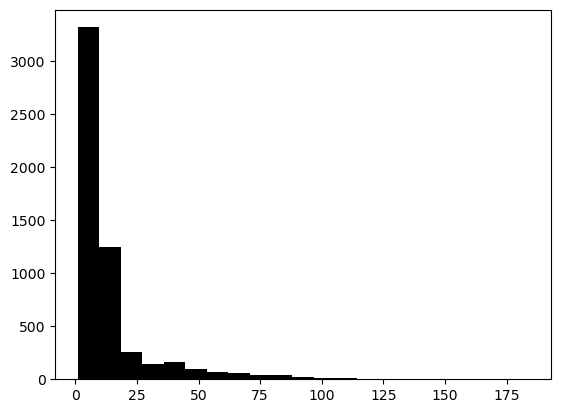

In [113]:
import pandas as pd
df_info = pd.read_csv("AI-データサイエンスのための図解でわかる数学プログラミング/MathProgramming/Chapter1-jupyter/accomodation_info.csv", index_col=0, parse_dates=[0])
df_info

x = df_info['顧客ID'].value_counts()
x_hist,t_hist,_ = plt.hist(x,21,color="k")
plt.show()

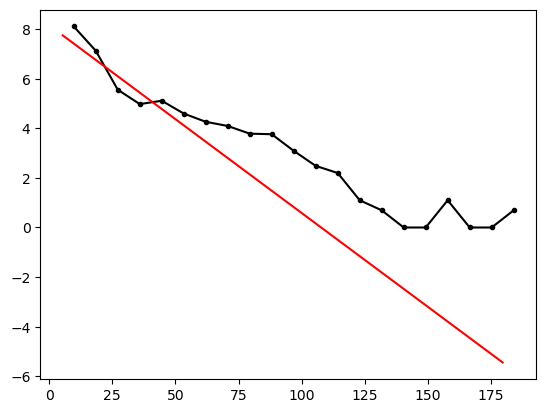

In [114]:
# 第1章 分布の近似曲線

import numpy as np
import matplotlib.pyplot as plt
import math

# パラメータ設定
epsiron = 1
num = 15

# 変数設定
weight = x_hist[1:num]
t = np.zeros(len(t_hist)-1)
for i in range(len(t_hist)-1):
    t[i] = (t_hist[i]+t_hist[i+1])/2

# フィッティング（最小二乗近似）によるパラメータの算出
a, b = np.polyfit(t[1:num], np.log(x_hist[1:num]), 1, w=weight)

# フィッティング曲線（直線）の描画
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = a*t[i]+b
plt.plot(t_hist[1:], np.log(x_hist+epsiron),marker=".",color="k")
plt.plot(t,xt,color="r")
plt.show()

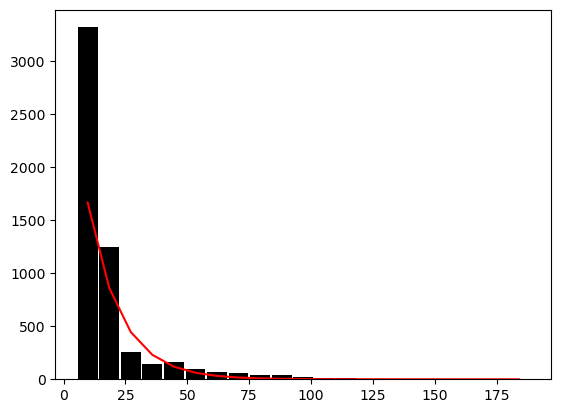

In [115]:
t = t_hist[1:]
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = math.exp(a*t[i]+b)

plt.bar(t_hist[1:], x_hist,width=8,color="k")
plt.plot(t,xt,color="r")
plt.show() 

In [116]:
# 第2章 サポートベクトル回帰

# データの読み込み
import pandas as pd
df_info = pd.read_csv("AI-データサイエンスのための図解でわかる数学プログラミング/MathProgramming/Chapter2-jupyter/accomodation_info.csv", index_col=0, parse_dates=[0])
df_info

,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:02:21,110034,若松 花子,B,19000
2018-11-01 00:03:10,112804,津田 美加子,D,20000
2018-11-01 00:06:19,110275,吉本 美加子,D,20000
2018-11-01 00:08:41,110169,坂本 直人,B,19000
2018-11-01 00:12:22,111504,青山 零,A,15000
...,...,...,...,...
2020-10-31 23:38:51,110049,吉本 篤司,A,3000
2020-10-31 23:42:12,110127,喜嶋 浩,A,3000
2020-10-31 23:47:24,115464,藤本 明美,D,8000


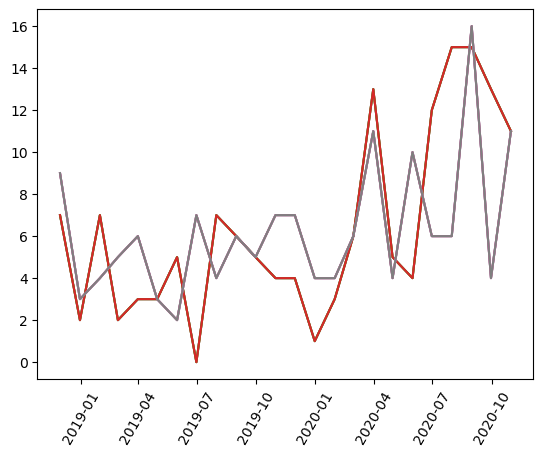

In [117]:
# 特徴ベクトル可視化

import pandas as pd
import matplotlib.pyplot as plt
# indexの抽出
x_0 = df_info.resample('M').count()
x_0 = x_0.drop(x_0.columns.values,axis=1)
# 順位の設定
i_rank = 1
j_rank = 2
# 顧客IDの抽出
i_id = df_info['顧客ID'].value_counts().index[i_rank]
j_id = df_info['顧客ID'].value_counts().index[j_rank]
# 月ごとの利用回数を特徴量として抽出
x_i = df_info[df_info['顧客ID']==i_id].resample('M').count()
x_j = df_info[df_info['顧客ID']==j_id].resample('M').count()
# 欠損値があった場合の穴埋め
x_i = pd.concat([x_0, x_i], axis=1).fillna(0)
x_j = pd.concat([x_0, x_j], axis=1).fillna(0)
# 描画
plt.plot(x_i)
plt.plot(x_j)
plt.xticks(rotation=60)
plt.show()

In [118]:
#  特徴ベクトル抽出

import pandas as pd
# indexの調整
x_0 = df_info.resample('M').count()
x_0 = x_0.drop(x_0.columns.values,axis=1)
# 配列を準備
list_vector = []
# 人数の設定
num = 100
for i_rank in range(num):
    # 顧客IDの抽出
    i_id = df_info['顧客ID'].value_counts().index[i_rank]
    # 月ごとの利用回数を特徴量として抽出
    x_i = df_info[df_info['顧客ID']==i_id].resample('M').count()
    # 欠損値があった場合の穴埋め
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)
    # 特徴ベクトルとして追加
    list_vector.append(x_i.iloc[:,0].values.tolist())

In [119]:
# クラスタリング(k-means法)による分類

from sklearn.cluster import KMeans
# クラスター数を設定
num_of_cluster = 4
# クラスターに分類
model = KMeans(n_clusters=num_of_cluster, random_state=0)
model.fit(features)
pred_class = model.labels_
print(pred_class)

[3 3 3 1 1 2 1 3 3 1 1 1 2 0 0 2 1 0 2 2 2 2 2 0 1 2 1 0 1 2 1 2 2 2 2 1 1
 1 0 0 1 2 1 0 0 2 0 2 1 2 2 0 2 0 2 1 1 2 1 2 0 0 1 2 1 2 1 0 0 2 1 2 1 1
 1 1 1 1 2 2 2 0 1 2 1 1 0 2 1 2 2 1 1 1 1 1 1 1 2 0]


In [120]:
# 目的変数・説明変数の設定

import numpy as np
# 分析したいクラスを設定する
target_class = 1
# 目的変数を作成する
num = len(pred_class)
data_o = np.zeros(num)
for i in range(num):
    if pred_class[i]==target_class:
        data_o[i] = True
    else:
        data_o[i] = False
print(data_o)

data_e = features  # 説明変数を作成する
print(data_e)

[0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0.]
[[ 5.  8.  8. ... 13. 10. 13.]
 [ 7.  2.  7. ... 15. 13. 11.]
 [ 9.  3.  4. ... 16.  4. 11.]
 ...
 [ 6.  6.  3. ...  3.  3.  5.]
 [ 0.  3.  2. ...  8.  6.  4.]
 [ 6.  3.  5. ...  1.  2.  0.]]


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


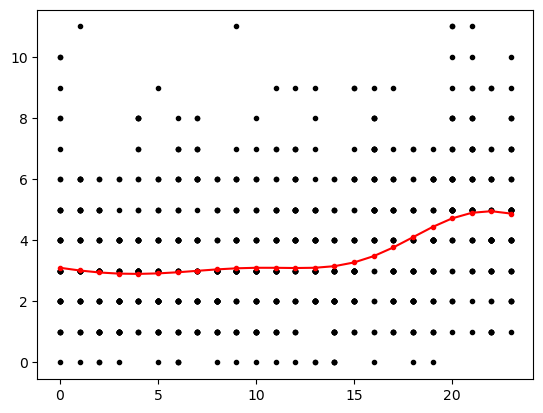

0.04579319549920835

In [121]:
# サポートベクトル回帰

from sklearn import svm
from sklearn.model_selection import train_test_split

# データを作成
data_target = data_e[data_o==1]
data_y = data_target
data_x = np.stack([np.arange(0,len(data_target[0])) for _ in range(len(data_target))], axis=0)
data_y = np.ravel(data_y)
data_x = np.ravel(data_x)

# データセットを訓練データとテストデータに分割
x_train, x_test, y_train, y_test = train_test_split(data_x,data_y)

# 訓練データによるモデル構築（サポートベクトル回帰）
model = svm.SVR(kernel='rbf', C=1)
reg = model.fit(x_train.reshape(-1, 1),y_train.reshape(-1, 1))

# 予測曲線を描画
x_pred = np.arange(len(data_target[0])).reshape(-1, 1)
y_pred = model.predict(x_pred)
plt.plot(data_x,data_y,"k.")
plt.plot(x_pred,y_pred,"r.-")
plt.show()

# 決定係数R^2
reg.score(x_test.reshape(-1, 1),y_test.reshape(-1, 1))